# ch04.02 UNet-Image segmentation

* 날짜: 2022-08-03
* 이름: 고민수

## 학습내용
    - Image multiclass segmentation에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Muticlass Segmenation



<p  align='center'>
<img src ='https://miro.medium.com/max/1400/1*B16t8Do6hvuq2Q_2YOM-UQ.png' width=500>
</p>


<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0402-01.PNG?raw=true' width=800>
</p>


In [3]:
import warnings
import sys, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from tensorflow.keras import utils, callbacks
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from keras_unet.metrics import iou, iou_thresholded # iou

warnings.filterwarnings(action='ignore')

In [98]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터셋: Crowd Instance-level Human Parsing (CIHP)
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

In [125]:
IMAGE_SIZE = 128
BATCH_SIZE = 4
NUM_CLASSES = 20

TRAIN_DIR = "D:Dataset/dataset/instance-level_human_parsing/Training/"
VALID_DIR = "D:Dataset/dataset/instance-level_human_parsing/Validation/"

train_images = glob(os.path.join(TRAIN_DIR, "Images/*"))
valid_images = glob(os.path.join(VALID_DIR, "Images/*"))

train_masks = glob(os.path.join(TRAIN_DIR, "Category_ids/*"))
valid_masks = glob(os.path.join(VALID_DIR, "Category_ids/*"))

print("Train data 개수 : ", len(train_images))
print("Train data 샘플 : ", train_images[0])
print("Valid data 개수 : ", len(valid_images))
print("Valid data 샘플 : ", valid_images[0])

Train data 개수 :  28280
Train data 샘플 :  D:Dataset/dataset/instance-level_human_parsing/Training/Images\0000006.jpg
Valid data 개수 :  5000
Valid data 샘플 :  D:Dataset/dataset/instance-level_human_parsing/Validation/Images\0000001.jpg


### read_image

In [137]:
image = tf.io.read_file(train_images[0]) # 이미지 파일을 읽어옴
print("\nimage shape : ", image.shape)
print("\nimage(before decode) : ", str(image)[:500])


image shape :  ()

image(before decode) :  tf.Tensor(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xf4\x01O\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00


#### No mask

In [127]:
image = tf.image.decode_png(image, channels=1)
print("\nimage(after decode) shape : ", image.shape)
print("\nimage[0].shape : ", image[0].shape)
image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
print("\nimage(after resize) shape : ", image.shape)


image(after decode) shape :  (500, 335, 1)

image[0].shape :  (335, 1)

image(after resize) shape :  (128, 128, 1)


#### mask

In [138]:
image = tf.image.decode_png(image, channels=1)
print("\nimage(after decode) shape : ", image.shape)
print("\nimage[0][:10] : ", image[0][:10])
image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
print("\nimage(after resize) shape : ", image.shape)
image = image / 127.5 - 1
print("\nimage[0][:10] : ", image[0][:10])


image(after decode) shape :  (500, 335, 1)

image[0][:10] :  tf.Tensor(
[[88]
 [60]
 [55]
 [63]
 [60]
 [65]
 [66]
 [48]
 [49]
 [43]], shape=(10, 1), dtype=uint8)

image(after resize) shape :  (128, 128, 1)

image[0][:10] :  tf.Tensor(
[[-0.43845648]
 [-0.43052   ]
 [-0.37086684]
 [-0.4931066 ]
 [-0.5891903 ]
 [-0.61708313]
 [-0.5305501 ]
 [-0.6564132 ]
 [-0.81609845]
 [-0.83958334]], shape=(10, 1), dtype=float32)


In [129]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path) # 이미지 파일 읽기
    if mask:
        image = tf.image.decode_png(image, channels=1) # 디코딩, 
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image

### load_data / data_generator

In [130]:
def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

In [131]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

### dataset

In [132]:
train_dataset = data_generator(train_images, train_masks)
valid_dataset = data_generator(valid_images, valid_masks)
print("Train Dataset:", train_dataset)
print("Valid Dataset:", valid_dataset)

Train Dataset: <PrefetchDataset shapes: ((4, 128, 128, 3), (4, 128, 128, 1)), types: (tf.float32, tf.float32)>
Valid Dataset: <PrefetchDataset shapes: ((4, 128, 128, 3), (4, 128, 128, 1)), types: (tf.float32, tf.float32)>


## U-Net

### 모델링

In [133]:
model = custom_unet((128,128,3),
                    num_classes=20,
                    filters=32, 
                    output_activation='softmax',
                    )
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 128, 128, 32) 128         conv2d_57[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_15 (SpatialDr (None, 128, 128, 32) 0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

### 컴파일 및 학습

In [134]:
model_filename = 'model/multi_seg_model_v0.h5'
callback_checkpoint = callbacks.ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [135]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = loss,
    metrics=["acc"]
)

In [136]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=25)

Epoch 1/25
7070/7070 [==============================] - 245s 31ms/step - loss: 1.3817 - acc: 0.6044 - val_loss: 0.8837 - val_acc: 0.7193
Epoch 2/25
7070/7070 [==============================] - 230s 32ms/step - loss: 0.9294 - acc: 0.7060 - val_loss: 0.7694 - val_acc: 0.7572
Epoch 3/25
7070/7070 [==============================] - 233s 33ms/step - loss: 0.8280 - acc: 0.7365 - val_loss: 0.7065 - val_acc: 0.77401 - acc: 
Epoch 4/25
7070/7070 [==============================] - 238s 34ms/step - loss: 0.7786 - acc: 0.7512 - val_loss: 0.6973 - val_acc: 0.7770
Epoch 5/25
7070/7070 [==============================] - 239s 34ms/step - loss: 0.7449 - acc: 0.7618 - val_loss: 0.6560 - val_acc: 0.7920
Epoch 6/25
7070/7070 [==============================] - 224s 32ms/step - loss: 0.7201 - acc: 0.7696 - val_loss: 0.6425 - val_acc: 0.7953
Epoch 7/25
7070/7070 [==============================] - 221s 31ms/step - loss: 0.7004 - acc: 0.7763 - val_loss: 0.6344 - val_acc: 0.7995
Epoch 8/25
7070/7070 [==========

### 결과

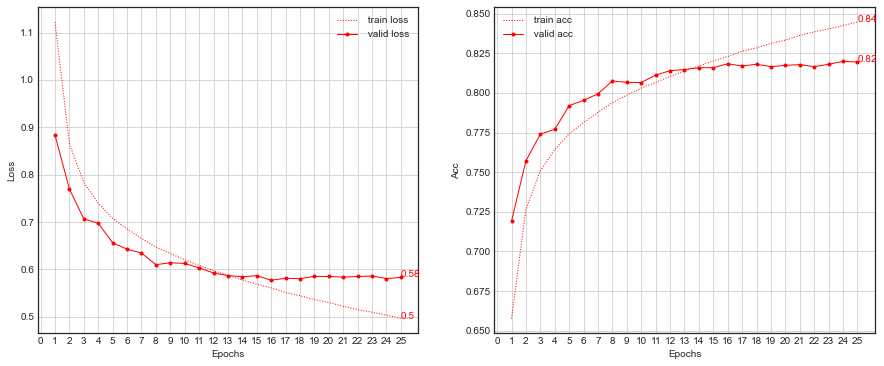

In [140]:
from Myfunc import show_lcurve
show_lcurve([history],[""],size=(15,6))

### Colormap Overlay

In [142]:
from scipy.io import loadmat
colormap = loadmat("D:Dataset/dataset/instance-level_human_parsing/human_colormap.mat")["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

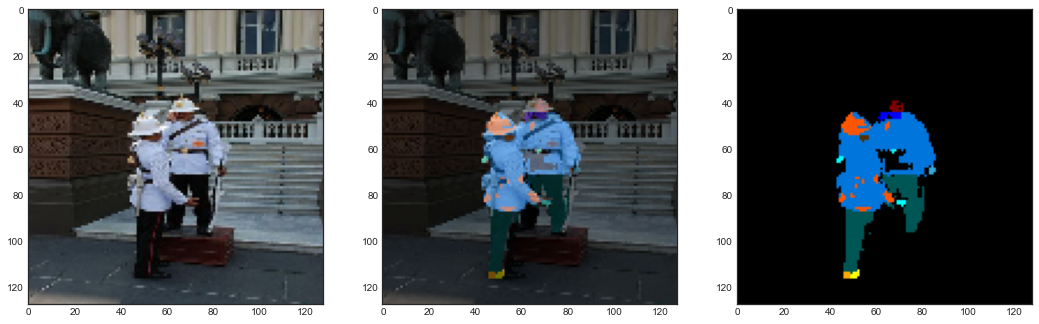

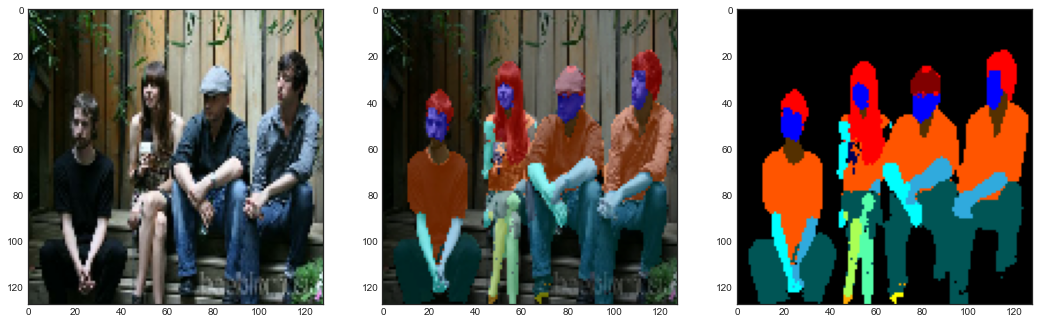

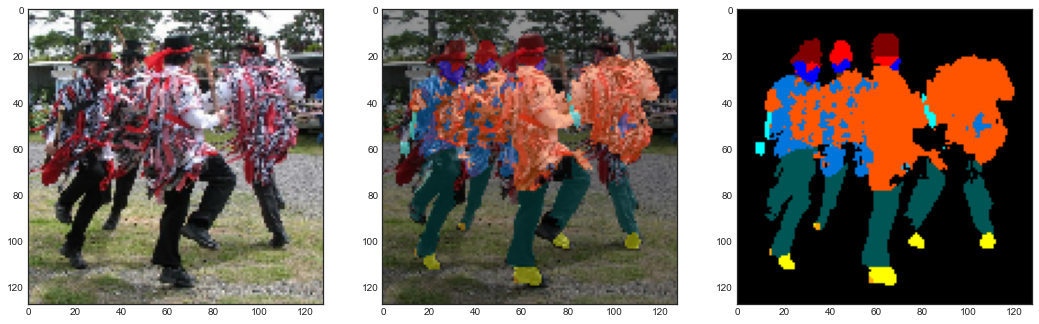

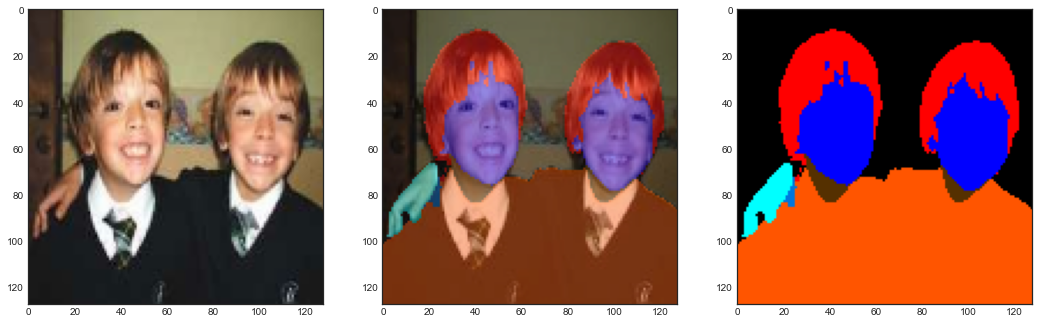

In [144]:
import cv2
plot_predictions(train_images[:4], colormap, model=model)